In [15]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import sacc
import pyccl as ccl
import time

# tjpcov packages
from tjpcov.covariance_calculator import CovarianceCalculator
from tjpcov.covariance_cluster_counts_ssc import ClusterCountsSSC

# plotting settings
%matplotlib inline
plt.rcParams['xtick.labelsize'] = 13.
plt.rcParams['ytick.labelsize'] = 13.
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top']       = True
plt.rcParams['ytick.right']     = True

# Cluster count covariance: validation

<br>
<font size="4">
The Gaussian and SSC terms of the number count covariance computed by TJPCov are validated against the corresponding predictions from an external code.
</font>
<br>
<br>
<font size="4">
The reference external code has been validated against simulations in Fumagalli et al. 2021 (arXiv:2102.08914). The code is based on Hu$\&$Kravtsov 2001 model (arXiv:astro-ph/0203169v1), and adapted to lightcone geometry  in Costanzi+19 (arXiv:1810.09456v1)
</font>

In [4]:
# read redshift bins, richness bins and survey area from the config file
INPUT_YML = "./clusters/conf_covariance_clusters.yaml"
cc_cov    = ClusterCountsSSC(INPUT_YML)
zbins     = cc_cov.z_bins
lbins     = cc_cov.richness_bins
Omega_sky = cc_cov.survey_area


# plot for covariance comparison
zbins_m = (zbins[1:]+zbins[:-1])/2
xtk_zl = []
for i in range(len(lbins)-1):
    for j in range(len(zbins_m)):
        xtk_zl += [zbins_m[j]]

xtk_zl = np.append(xtk_zl,zbins[-1])
xtk_zl = np.round(np.array(xtk_zl),2)

nl     = len(lbins)-1
nz     = len(zbins)-1
len_nc = nz * nl



# plot for comparing the tjpcov covariance to the reference covariance from an external code 
def comparison_plot_func(cov_ref, cov, cvec, title, label):

    fig = plt.figure(figsize=(10,8))
    ax0 = fig.add_axes([0.2, 0.3, 0.6, 0.6],xticklabels=[])
    ax1 = fig.add_axes([0.2, 0.10, 0.6, 0.2])

    plt.sca(ax0)
    
    plt.plot(np.diag(cov_ref,k=0), 'X',c=cvec[0],mec='k',ms=8, label=label[0])
    plt.plot(np.diag(cov,k=0),lw=2.,c=cvec[1],label=label[1])

    if len(cvec)>2:
        plt.plot(np.diag(cov_ref,k=1), 'X',c=cvec[2],mec='k',ms=8, label=label[2])
        plt.plot(np.diag(cov,k=1),lw=2.,c=cvec[3],label=label[3]) 
                
    plt.axhline(0., c='k', ls='--',lw=1)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
    plt.legend(loc=0,fontsize=12.5)
    plt.title(title,fontsize=18)
    plt.ylabel(r'Covariance', fontsize=15)

    plt.xticks(np.linspace(0,len_nc,len(lbins)),[])
    plt.xticks(np.linspace(0,len_nc,len(xtk_zl)),[], minor=True);


    plt.sca(ax1)

    diff = (np.diag(cov,k=0)/np.diag(cov_ref,k=0) - 1)*100
    plt.plot(diff, lw=2., c=cvec[1])
    if len(cvec)>2:
        diff = (np.diag(cov,k=1)/np.diag(cov_ref,k=1) - 1)*100
        plt.plot(diff, lw=2., c=cvec[3])
         
    plt.axhline(0., c='k',ls='--',lw=1)
    plt.ylabel(r'$\Delta$C/C$_{\rm ref}$ (%)', fontsize=15)
    plt.xticks(np.linspace(0,len_nc,len(lbins)),lbins.astype(int),fontsize=15,rotation=0)
    plt.xticks(np.linspace(0,len_nc,len(xtk_zl)),xtk_zl, minor=True,fontsize=10,rotation=45);
    plt.xlabel(r'Richness & redshift bins', fontsize=15)


# Gaussian covariance  (i.e. shot-noise)
<br>
\[
\Large{
{\rm Gauss}_{ij} =  \langle N\rangle(\Delta z_i,\Delta \lambda_i)\,\langle N \rangle(\Delta z_j,\Delta \lambda_j) \, \delta^{\rm D}_{ij}
}
\]
<font size="4">with:</font><br><br>
<font size="4">- expected number of clusters:</font><br><br>
\[
\large{
\langle N\rangle(\Delta z_i,\Delta \lambda_i) = \int_0^\infty {\rm d}z \, \dfrac{{\rm d}V}{{\rm d}z} (z, \Delta z_i)\,\int_0^\infty {\rm d}M\, n(M,z)\,\int_{\Delta \lambda_i} {\rm d}\lambda^{\rm ob} \, P(\lambda^{\rm ob} | M,z)
}
\]
<br>
<font size="4">- observed volume element:</font><br><br>
\[
\large{
\dfrac{{\rm d}V}{{\rm d}z} (z, \Delta z_i) = \Omega_{\rm mask}\,\frac{{\rm d}V}{{\rm d}z\,{\rm d}\Omega}(z)\,\int_{\Delta z_i} {\rm d}z^{\rm ob}\,P(z^{\rm ob} | z)
}
\]
<br>

# Super-sample covariance
<br>
\[
\Large{
\begin{align}
SSC_{ij} = \,& \int_o^\infty dz\,\frac{{\rm d}V}{{\rm d}z}(z,\Delta z_i)\,D(z)\,\langle Nb\rangle(z,\Delta \lambda_i)  \, \times  \\
 & \int_o^\infty dz'\,\frac{{\rm d}V}{{\rm d}z}(z', \Delta z_j)\,D(z')\,\langle Nb\rangle(z',\Delta \lambda_j) \ \ \sigma^2(z,z')
\end{align}
}
\]
<br><br><br>
<font size="4">with:</font><br><br>
<font size="4">- number counts times halo bias:</font><br><br>
<br>
\[
\large{
\langle Nb\rangle(z,\Delta \lambda_i) = \int_0^\infty {\rm d}M\, n(M,z)\,b(M,z)\,\int_{\Delta \lambda_i} {\rm d}\lambda^{\rm ob} \, P(\lambda^{\rm ob} | M,z)
}
\]
<br>
<font size="4">- sample covariance:</font><br><br>
\[
\Large{
\sigma^2(z,z') = \int \frac{d^3 k}{(2\pi)^3}\, P_0(k) \ W(kr_z) \ W^*(kr_{z'})
}
\]
<br>
<font size="4">- window function (angle-averaged spherical harmonic expansion of $e^{ikr}$ ):</font><br><br>
\[
\Large{
W(kr_z) = 4\pi\,\sum_{\ell=0}^\infty (i)^\ell\,j_\ell(kr_z)\,Y_{\ell 0}(\hat{k})\,K_\ell
}
\]
<br>
\[
K_\ell =
\large{
\begin{cases}
\frac{1}{2\sqrt{\pi}} \quad && {\rm for}\quad  l=0 \\ 
\sqrt{\frac{\pi}{2l+1}}\frac{P_{l-1}(\cos(\theta_s))-P_{l+1}(\cos(\theta_s))}{\Omega_{\rm mask}} \quad && {\rm for}\quad  l\neq 0  
\end{cases}
}
\]

<br>
<br>
<br>
<font size="4">Full-sky approx: $\ell = 0$</font><br>
<font size="4">Partial-sky model: $\ell = 0, ..., \infty$ (good approx: $\ell = 0, ..., 20$) </font><br><br>

### RESHAPE: The two redshift integrations are actually independent and can thus be separated. Furthermore, we can simplify the computation by considering the redshift-averaged window functions 
<br>
<br>
\[
\Large{
SSC_{ij} =  \langle Nb\rangle(\Delta z_i,\Delta \lambda_i)\,\langle Nb \rangle(\Delta z_j,\Delta \lambda_j) \int \frac{d^3 k}{(2\pi)^3}\, P_0(k) \sum_\ell W^i_\ell (k)\,W^j_\ell(k)
}
\]
<font size="4">with</font><br><br>
<font size="4">- number count times halo bias:</font><br><br>
<br>
\[
\large{
\langle Nb\rangle(\Delta z_i,\Delta \lambda_i) = \int_0^\infty {\rm d}z \, \dfrac{{\rm d}V}{{\rm d}z} (z, \Delta z_i)\,\int_0^\infty {\rm d}M\, n(M,z)\,b(M,z)\,\int_{\Delta \lambda_i} {\rm d}\lambda^{\rm ob} \, P(\lambda^{\rm ob} | M,z)
}
\]

<br>
<font size="4">- redshift shell window function (with lightcone geometry):</font><br><br>
\[
\large{
W^i_\ell(k) = \dfrac{1}{V_i}\,\int_0^\infty {\rm d}z \, \dfrac{{\rm d}V}{{\rm d}z} (z, \Delta z_i)\,D(z)\,\bigg[4\pi\,j_\ell(k\,r_z)\,K_\ell \bigg]
}
\]
<br>

# Load covariance generated by the external code (reference for validation)
<font size="4">External code validated against simulations in Fumagalli+21 (arXiv:2102.08914v1).</font><br><br>

In [5]:
# partial-sky model, sigma_z=0.005 (DES Y1 photoz)
ref_cov = np.load('../tests/data/clusters/ref_cov_partialsky_sigmaz0.005.npz')
cov_ref_gauss_005 = ref_cov['sn']
cov_ref_ssc_005   = ref_cov['ssc']

# partial-sky model, sigma_z=0.05 (large photo-z)
ref_cov = np.load('../tests/data/clusters/ref_cov_partialsky_sigmaz0.05.npz')
cov_ref_gauss_05 = ref_cov['sn']
cov_ref_ssc_05   = ref_cov['ssc']

# full-sky model, sigma_z=0.005 (DES Y1 photoz)
ref_cov = np.load('../tests/data/clusters/ref_cov_fullsky_sigmaz0.005.npz')
cov_ref_gauss_full_005 = ref_cov['sn']
cov_ref_ssc_full_005   = ref_cov['ssc']

## Partial-sky exact model vs full-sky approximation
<font size="4"> The previous version of the TJPCov code relied on full-sky approximation for describing the super-sample covariance. </font><br><br>
<font size="4">The super-sample covariance depends on the size and geometry of the survey; thus, the full-sky approximation is not a good approximation, as it underestimates the sample variance effect.</font><br><br>

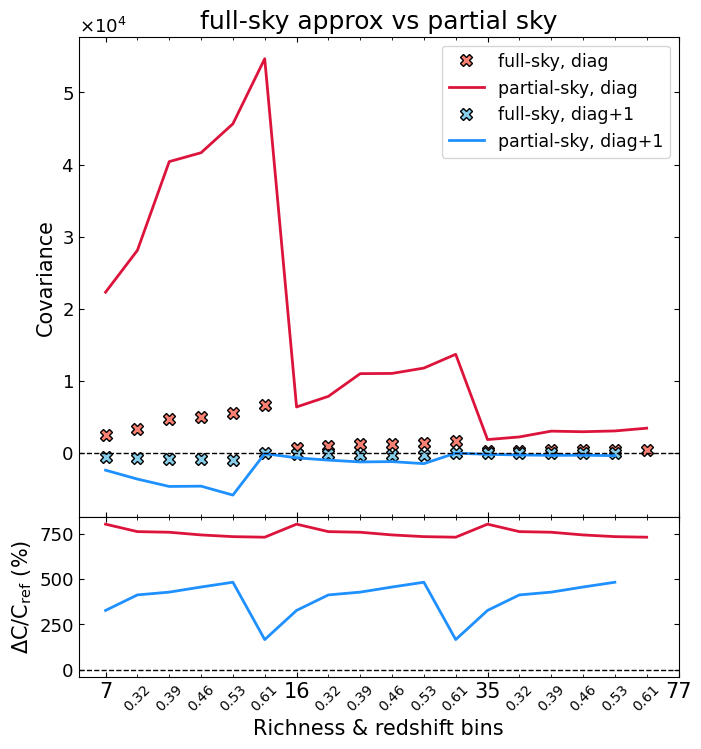

In [7]:
comparison_plot_func(cov_ref_ssc_full_005, cov_ref_ssc_005,  
                     cvec  = ['salmon','crimson', 'skyblue','dodgerblue'], 
                     title = r'full-sky approx vs partial sky' , 
                     label = ['full-sky, diag', 'partial-sky, diag', 'full-sky, diag+1', 'partial-sky, diag+1'])

# Note: the labels "diag" and "diag+1" refer to the diagonal and first off-diagonal (w.r.t. redshifts bins)
# elements of the matrix, respectively.

# Run TJPCOV (new version)  for computing the covariance terms
<font size="4">The new version of the code accounts for the actual size of the survey (no full-sky approximation).<br>Computing time ~ 30-60 sec (for 6 redshift bins, 3 richness bins).</font><br><br>


In [6]:
# # compute covariance terms from the covariance class (and save results in a .sacc file)
# st = time.time()
# cc = CovarianceCalculator("./clusters/conf_covariance_clusters.yaml")
# cc.config['photo-z']['sigma_0'] = 0.05

# cov_terms     = cc.get_covariance_terms()
# sacc_with_cov = cc.create_sacc_cov(output="test_cov_new_05.sacc", save_terms=True)
# print('Time: ', (time.time()-st), ' sec')

Computing independent covariance blocks
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_1')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_0')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich

Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_0')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_5')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0')
Rank None: ('NC_mock_red

Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_5')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_1')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_2')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_3')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_4')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_5')
Rank None: ('NC_mock_red

('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_0')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4')
('NC_mock_

('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_1')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_2')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_3')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_4')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_5')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4')
('NC_mock_

Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_1')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_2')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_3')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_4')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_5')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_1'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_1')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_1'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2')
Rank None: ('NC_mock_red

Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_0')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_5')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0')
Rank None: ('NC_mock_red

Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_4')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_5'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_5')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_1')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_2')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_3')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_4')
Rank None: ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0'), ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_5')
Rank None: ('NC_mock_red

('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_4')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_5')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_4')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_5')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_0')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_1')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2')
('NC_mock_redshift_richness', 'bin_rich_0', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3')
('NC_mock_

('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_4')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_2') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_5')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_4')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_5')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_0')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_1')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_2')
('NC_mock_redshift_richness', 'bin_rich_1', 'bin_z_3') ('NC_mock_redshift_richness', 'bin_rich_2', 'bin_z_3')
('NC_mock_

## Load covariance generated by TJPCOV and saved into a .sacc file

In [8]:
# partial-sky model, sigma_z=0.005 (DES Y1 photoz)
cov_tjp_gauss_005 = sacc.Sacc.load_fits('../tests/data/clusters/test_cov_new_005_gauss.sacc').covariance.covmat[:len_nc,:len_nc]
cov_tjp_ssc_005   = sacc.Sacc.load_fits('../tests/data/clusters/test_cov_new_005_SSC.sacc').covariance.covmat[:len_nc,:len_nc]

# partial-sky model, sigma_z=0.05 (large photoz)
cov_tjp_gauss_05 = sacc.Sacc.load_fits('../tests/data/clusters/test_cov_new_05_gauss.sacc').covariance.covmat[:len_nc,:len_nc]
cov_tjp_ssc_05   = sacc.Sacc.load_fits('../tests/data/clusters/test_cov_new_05_SSC.sacc').covariance.covmat[:len_nc,:len_nc]

## Validation: Gaussian covariance

(-0.00012, 0.00012)

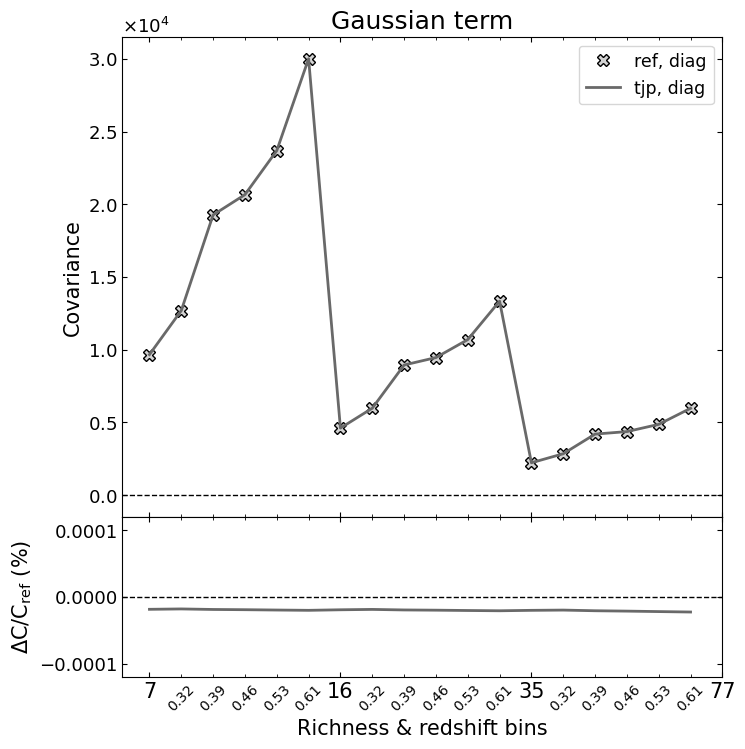

In [9]:
comparison_plot_func(cov_ref_gauss_005, cov_tjp_gauss_005,  
                     cvec  = ['lightgray','dimgray'], 
                     title = r'Gaussian term' , 
                     label = ['ref, diag', 'tjp, diag', 'ref, diag+1', 'tjp, diag+1'])

plt.ylim(-1.2e-4,1.2e-4)

## Validation: Super-sample covariance, small photo-z


(-0.0005, 0.00025)

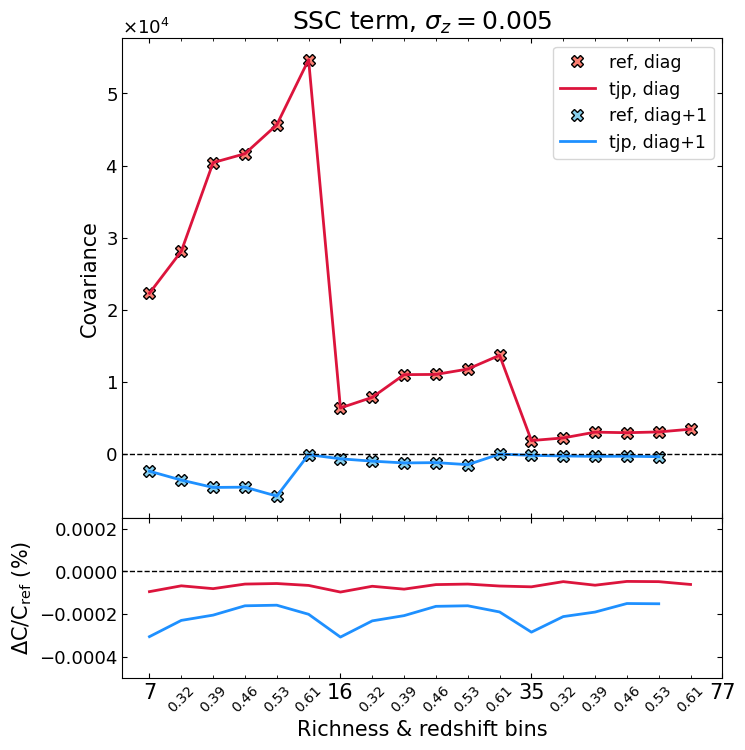

In [12]:
comparison_plot_func(cov_ref_ssc_005, cov_tjp_ssc_005,  
                     cvec=['salmon','crimson', 'skyblue','dodgerblue'], 
                     title=r'SSC term, $\sigma_z=0.005$' , 
                     label = ['ref, diag', 'tjp, diag', 'ref, diag+1', 'tjp, diag+1'])

plt.ylim(-5e-4,2.5e-4)

## Validation: Super-sample covariance, large photo-z

(-0.015, 0.05)

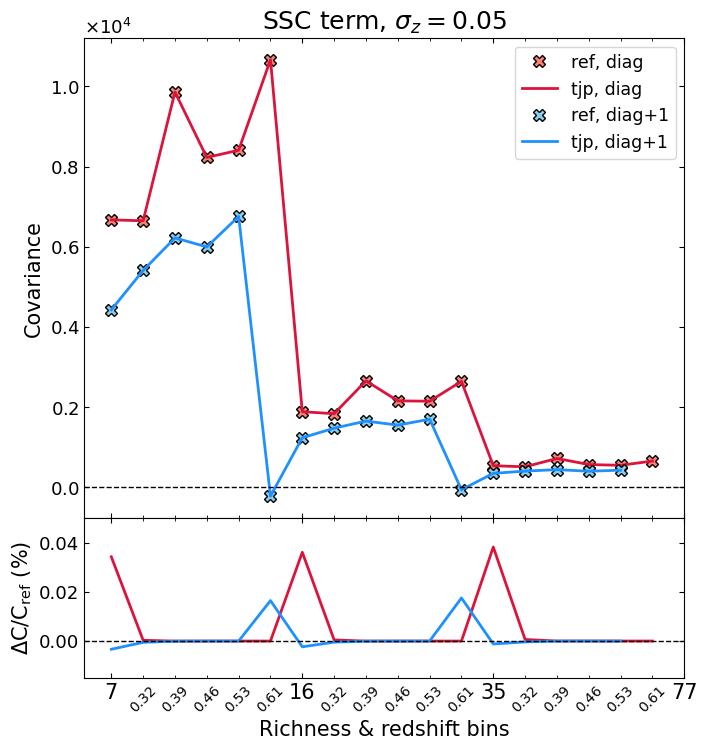

In [14]:
comparison_plot_func(cov_ref_ssc_05, cov_tjp_ssc_05,  
                     cvec=['salmon','crimson', 'skyblue','dodgerblue'], 
                     title=r'SSC term, $\sigma_z=0.05$', 
                     label = ['ref, diag', 'tjp, diag', 'ref, diag+1', 'tjp, diag+1'])

plt.ylim(-1.5e-2,5e-2)